# Descriptive data analysis and pre-processing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


#Upload CSV file
data = pd.read_csv("Data/pd_speech_features.csv")

In [2]:
print(data.iloc[:,:10].head())

   id  gender      PPE      DFA     RPDE  numPulses  numPeriodsPulses  \
0   0       1  0.85247  0.71826  0.57227        240               239   
1   0       1  0.76686  0.69481  0.53966        234               233   
2   0       1  0.85083  0.67604  0.58982        232               231   
3   1       0  0.41121  0.79672  0.59257        178               177   
4   1       0  0.32790  0.79782  0.53028        236               235   

   meanPeriodPulses  stdDevPeriodPulses  locPctJitter  
0          0.008064            0.000087       0.00218  
1          0.008258            0.000073       0.00195  
2          0.008340            0.000060       0.00176  
3          0.010858            0.000183       0.00419  
4          0.008162            0.002669       0.00535  


In [3]:
# General information of the dataset
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 756 entries, 0 to 755
Columns: 755 entries, id to class
dtypes: float64(749), int64(6)
memory usage: 4.4 MB
None


In [4]:
# Total number of null data
print(data.isnull().sum().sum())

0


In [ ]:
#Print indx and column name
for idx, col in enumerate(data.columns):
    print({idx}, {col})

In [5]:
# Descriptive statistics of the first 15 columns and the last one
print(data.iloc[:,list(range(10))+[-1]].describe())

               id      gender         PPE         DFA        RPDE   numPulses  \
count  756.000000  756.000000  756.000000  756.000000  756.000000  756.000000   
mean   125.500000    0.515873    0.746284    0.700414    0.489058  323.972222   
std     72.793721    0.500079    0.169294    0.069718    0.137442   99.219059   
min      0.000000    0.000000    0.041551    0.543500    0.154300    2.000000   
25%     62.750000    0.000000    0.762833    0.647053    0.386537  251.000000   
50%    125.500000    1.000000    0.809655    0.700525    0.484355  317.000000   
75%    188.250000    1.000000    0.834315    0.754985    0.586515  384.250000   
max    251.000000    1.000000    0.907660    0.852640    0.871230  907.000000   

       numPeriodsPulses  meanPeriodPulses  stdDevPeriodPulses  locPctJitter  \
count        756.000000        756.000000          756.000000    756.000000   
mean         322.678571          0.006360            0.000383      0.002324   
std           99.402499          

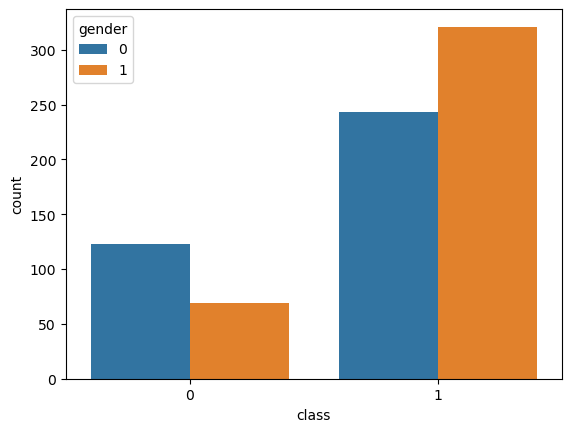

In [6]:
# Descriptive: number of observations per gender and class
sns.countplot(x=data["class"], hue=data["gender"])
plt.show()

For the first descriptibes obtained:

Dataset has 756 rows and 755 columns (749 float numbers, 64 integer)
Fisrt column is patient ID, second column is gender (integer that has to be replaced for a categorical variable) last column is class (also represented as integer).

For the gender variable there is a balanced data for men and women.    
For the class variable there is no balance data: It's about 3/4 of data for Parkinson patients and 1/4 of data for healthy subjects.

There is no null data. 

Data requires normalization: variable PPE min value is arround 0.045 and it's maximum is arround 0.9 with a mean at 0.74. Variable numPulses has a min value of 2 and a max value of 907 with a mean of arround 324. 

## Standarization

For standarization, use MinMaxScaler. 



In [7]:
# MinMaxScaler normalization

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1)) 
data_scaled = scaler.fit_transform(data.iloc[:,1:754])
scaled_df = pd.DataFrame(data_scaled, columns=data.columns[1:754])
scaled_data = pd.concat([data.iloc[:,:1], scaled_df, data.iloc[:,754]], axis=1)


In [8]:
# Create new file with scaled data
scaled_data.to_csv("Data/scaled_data.csv", index=False)

## Statistical analysis 

### Shapiro Wilk: normality test

Each variable will be tested for normality using Shapiro Wilk test. Each variable is separated according to Class variable. Then statistical test is applied individually to each variable separated according to Class.     
A new dataframe with results is generated, with information about variable, Class, p-value and a boolean to classify normal distribution (True) and not normal distribution (False).

In [9]:
from scipy.stats import shapiro

norm_results = []

for variable in scaled_data.columns[2:754]:
    for Class in scaled_data.iloc[:, 754].unique():
        subset = scaled_data.loc[scaled_data.iloc[:, 754] == Class, variable]
        
        # Statistical normality test: Shapiro-Wilk
        stat, p = shapiro(subset)
        
        # Store results test
        norm_results.append({
            "variable": variable,
            "class": Class,
            "p_value": round(p,5),
            "normal_dist": p >= 0.05  # True si és normal segons Shapiro-Wilk
        })

# Convert test results to dataframe
norm_results_df = pd.DataFrame(norm_results)

# Show first 10 results of the dataframe
print(norm_results_df.iloc[:10,])

           variable  class  p_value  normal_dist
0               PPE      1  0.00000        False
1               PPE      0  0.00000        False
2               DFA      1  0.00002        False
3               DFA      0  0.00301        False
4              RPDE      1  0.00320        False
5              RPDE      0  0.00200        False
6         numPulses      1  0.00003        False
7         numPulses      0  0.00005        False
8  numPeriodsPulses      1  0.00005        False
9  numPeriodsPulses      0  0.00005        False


/home/laura/anaconda3/lib/python3.9/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)


In [10]:
# Count how many variables splitted by class group are normally distributed

non_normal_count = norm_results_df["normal_dist"].value_counts()
print(non_normal_count)

normal_dist
False    1444
True       60
Name: count, dtype: int64


In [11]:
# Variables that are normally distributed in both class groups

norm_var = norm_results_df[norm_results_df["normal_dist"]==True]
norm_var = norm_var["variable"][norm_var["variable"].duplicated(keep=False)].unique()
print(norm_var)

['mean_MFCC_7th_coef' 'mean_MFCC_9th_coef' 'mean_MFCC_12th_coef'
 'tqwt_meanValue_dec_1' 'tqwt_meanValue_dec_2']


### Statistical comparison between groups

#### Mann-Whitney U test

Non normaly distributed variables are obtained, and the non-parametric test Mann-Whitney U is applied to determine differences for each variable according class group.

In [12]:
from scipy.stats import mannwhitneyu

diff_var = []  # List for statistically different variables
diff_results=[]  # List of all results

# Select all non-normaly distributed variables:
non_norm_variables = [variable for variable in scaled_data.columns[2:754] if variable not in norm_var]

for variable in non_norm_variables:
    
    # Create 2 class groups
    group_0 = scaled_data.loc[scaled_data['class'] == 0, variable]
    group_1 = scaled_data.loc[scaled_data['class'] == 1, variable]

    # Mann-Whitney U test
    stat, p = mannwhitneyu(group_0, group_1)

    # Store results
    diff_results.append({
        "variable": variable,
        "U_stat": stat,
        "p_value": round(p,5),
        "stat_diff": p <0.05   # True if statistically significant
    })
    
    if p<0.05:
        diff_var.append(variable)

diff_results_df = pd.DataFrame(diff_results)

In [13]:
print(diff_results_df.iloc[20:30,])

                      variable   U_stat  p_value  stat_diff
20  meanHarmToNoiseHarmonicity  71246.5  0.00000       True
21                minIntensity  76063.0  0.00000       True
22                maxIntensity  67845.0  0.00000       True
23               meanIntensity  71136.0  0.00000       True
24                          f1  74241.0  0.00000       True
25                          f2  69926.0  0.00000       True
26                          f3  49887.0  0.10341      False
27                          f4  53067.0  0.68043      False
28                          b1  46784.0  0.00487       True
29                          b2  55536.0  0.59445      False


In [14]:
# Count how many vairables are statistically significant according to group
print(len(diff_var))

528


In [15]:
print(diff_var[20:30])

['meanHarmToNoiseHarmonicity', 'minIntensity', 'maxIntensity', 'meanIntensity', 'f1', 'f2', 'b1', 'GQ_prc5_95', 'GQ_std_cycle_open', 'GQ_std_cycle_closed']


Plot few statistically significant non-normally distributed variables according to class group:

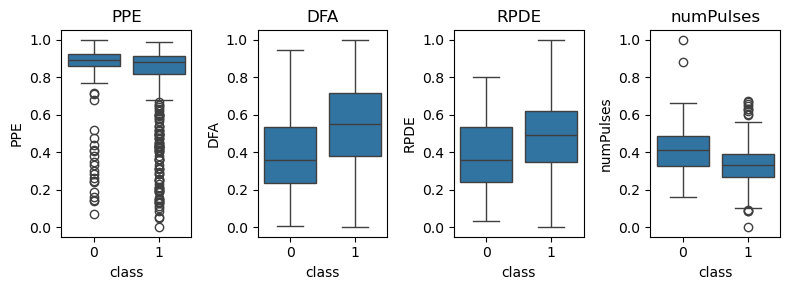

In [16]:
fig, axes = plt.subplots(1, 4, figsize=(8, 3))  

for i, col in enumerate(diff_var[:4]):  # Plot first 4 variables
    sns.boxplot(x=scaled_data["class"], y=scaled_data[col], ax=axes[i])
    axes[i].set_title(f"{col}")

plt.tight_layout() 
plt.show()

#### T-Test

Variables previously classified as normally distribued will be tested for statistical significance according to group with a T-Test with a 95% confidence.

In [17]:
from scipy.stats import ttest_ind

diff_n_results=[] # List all results
diff_varN = []    # List for statistically different variables

for variable in scaled_data[norm_var]:

    # Create 2 class groups
    group_0 = scaled_data.loc[scaled_data['class'] == 0, variable]
    group_1 = scaled_data.loc[scaled_data['class'] == 1, variable]

    # t-test
    stat, p = ttest_ind(group_0, group_1) 

    # Store results
    diff_n_results.append({
        "variable": variable,
        "U_stat": stat,
        "p_value": round(p,5),
        "stat_diff": p < 0.05,  # True if statistically significant
    })
    
    if p<0.05:
        diff_varN.append(variable)

diff_n_results_df = pd.DataFrame(diff_n_results)

In [18]:
print(diff_n_results_df)

               variable    U_stat  p_value  stat_diff
0    mean_MFCC_7th_coef -3.760535  0.00018       True
1    mean_MFCC_9th_coef -2.719644  0.00669       True
2   mean_MFCC_12th_coef -0.817776  0.41374      False
3  tqwt_meanValue_dec_1  0.391233  0.69574      False
4  tqwt_meanValue_dec_2  1.922055  0.05498      False


In [19]:
# Show vairables that are differently significant according to group
print(diff_varN)

['mean_MFCC_7th_coef', 'mean_MFCC_9th_coef']


Plot both statistically significant normal variables according to class group:

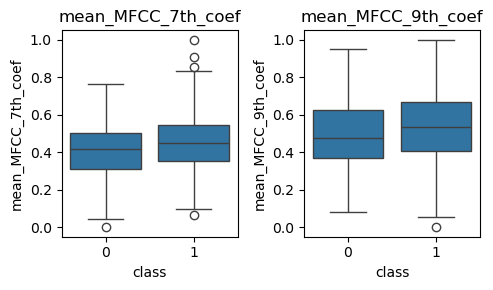

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(5,3)) 

for i, col in enumerate(diff_varN):
    sns.boxplot(x=scaled_data["class"], y=scaled_data[col], ax=axes[i])
    axes[i].set_title(f"{col}")

plt.tight_layout()
plt.show()

Create a new variable with all statistically significant variables with 95% confidence according to class. Few randomly selected features will be ploted against each other with a pairplot

/tmp/ipykernel_1300625/1156033909.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['class'] = scaled_data['class']


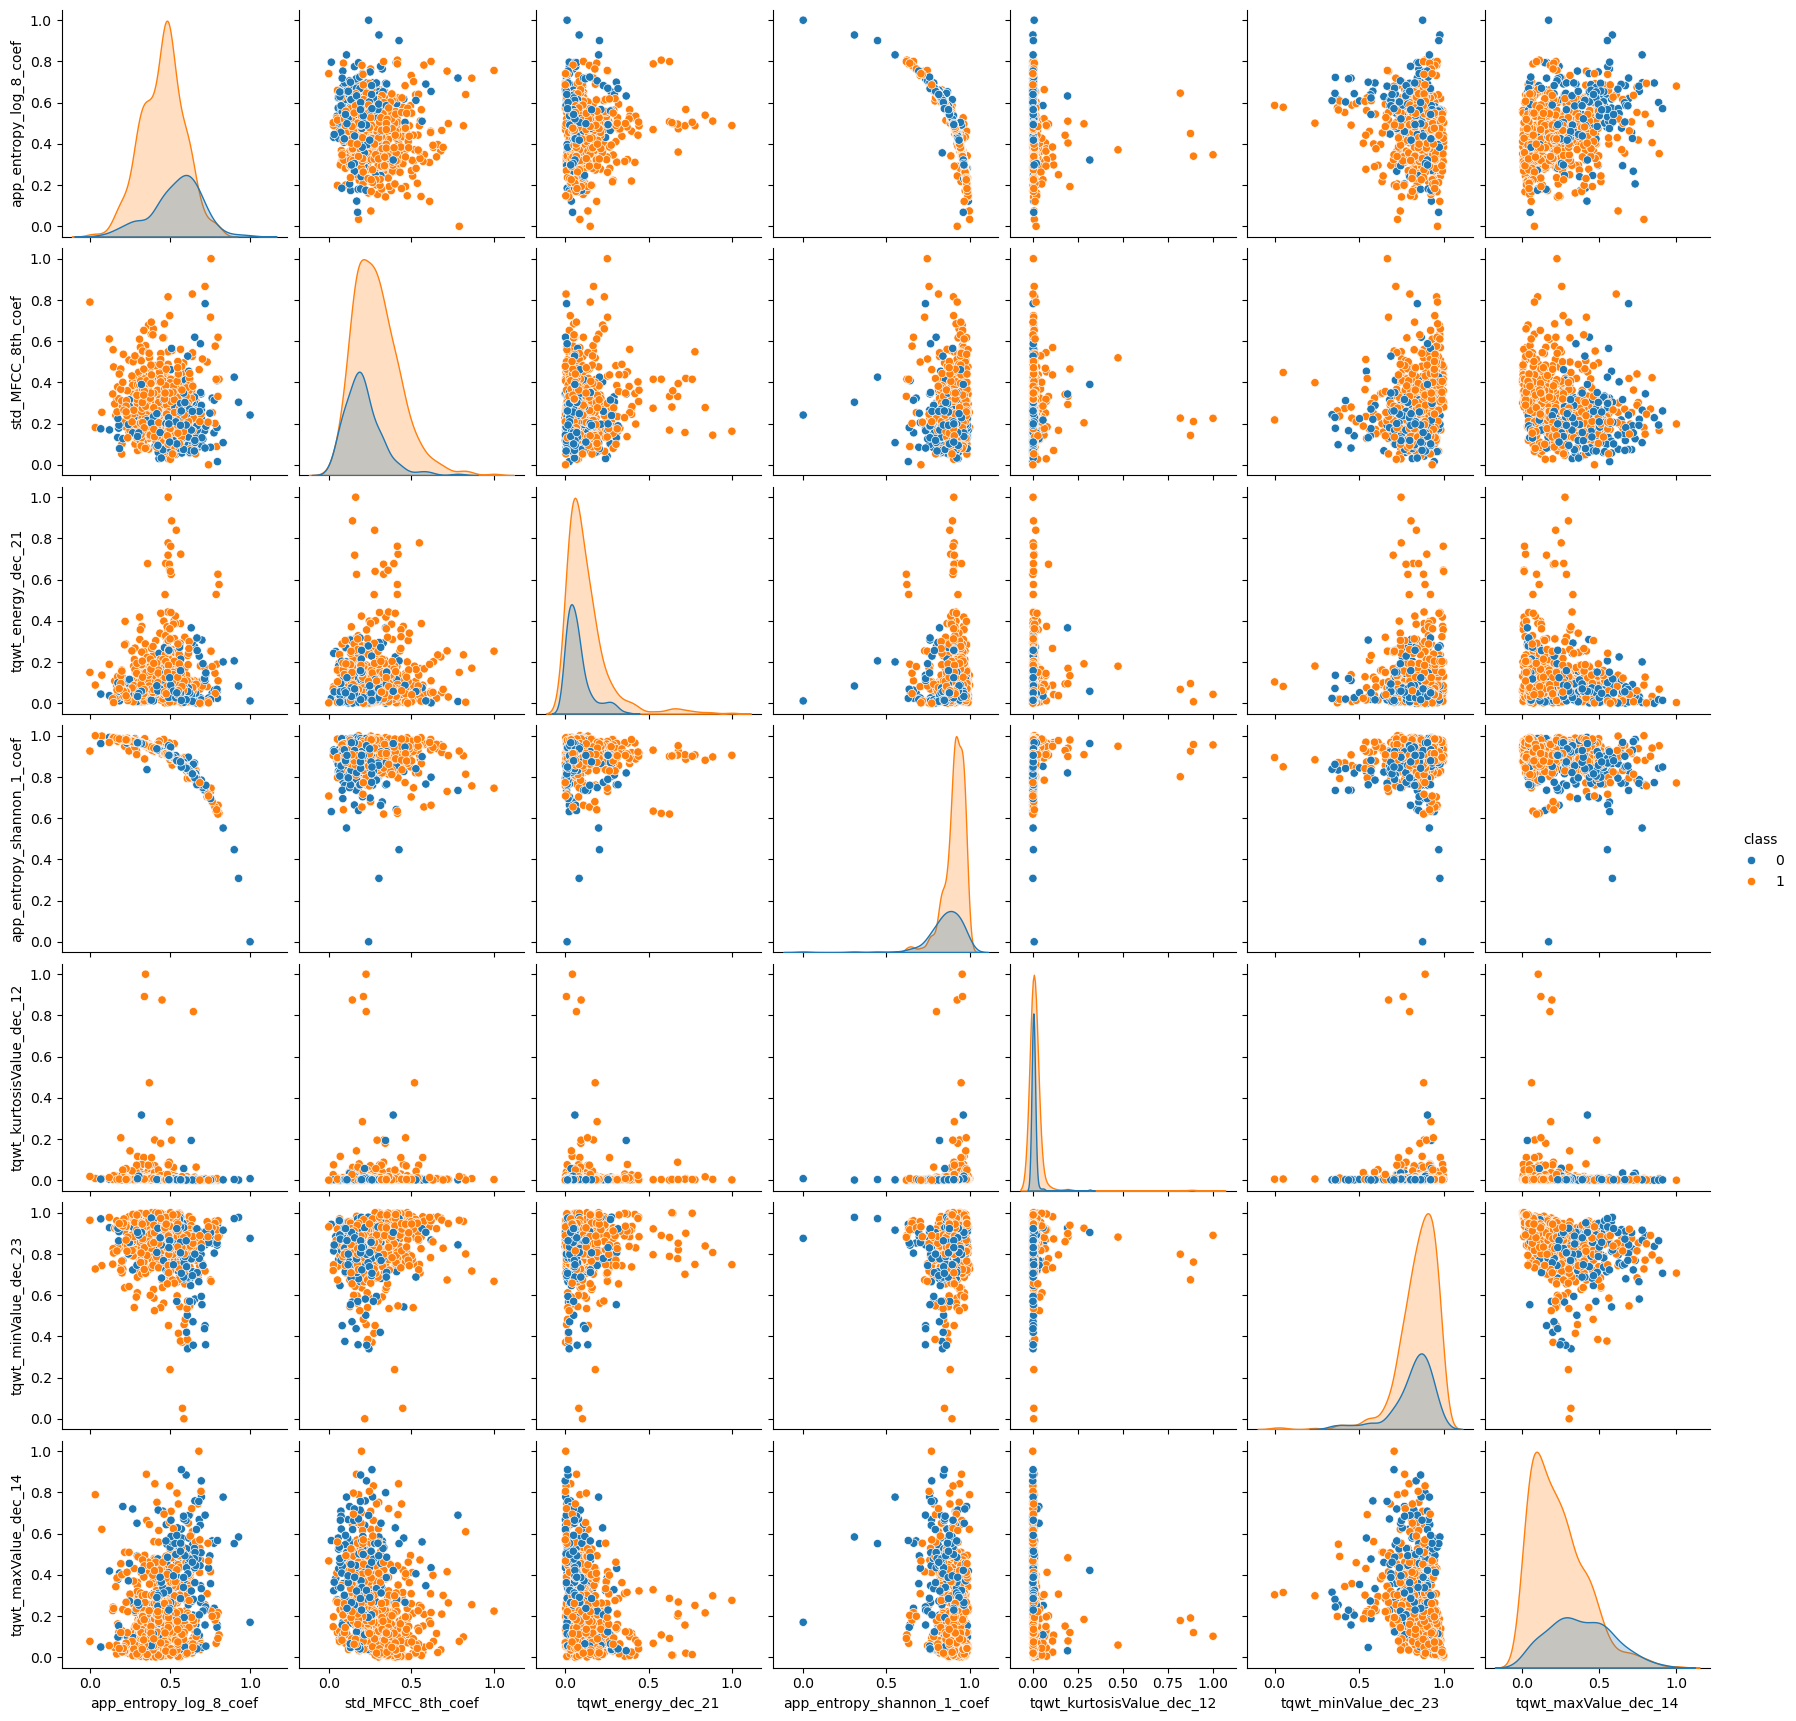

In [21]:
import random

significant_variables = diff_var + diff_varN   # New variable for all significant features

# Escullo 10 variables random de les significatives
random.seed(1)
rdm_var = random.sample(significant_variables,7)
subset = scaled_data[rdm_var]

subset['class'] = scaled_data['class']

sns.pairplot(subset, hue='class') # Color by class
plt.show()

Some of the randomly selected variables are related to each other. Additionally, while the blue and orange dots are interspersed across all graphs, in certain plots, they appear to cluster. For instance, in the top-right plot, blue dots are more localized at the top right part of the graph while orange dots tend to be more localized at the bottom-left region of samples distribution.